<a href="https://colab.research.google.com/github/galib96/lung-nodule-malignancy/blob/main/Lung_nodule_malignancy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import h5py
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, plot_confusion_matrix
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D, ZeroPadding2D, Add
from keras.layers import BatchNormalization, AveragePooling2D, Conv2D, MaxPooling2D, Input, ReLU
from keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.optimizers import Adam

In [2]:
data_label = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Lung Nodule Maliganancy/malignancy.csv")
data_label.head()

,Unnamed: 0,malignancy
0,0,1.0
1,1,1.0
2,2,1.0
3,3,1.0
4,4,1.0


In [3]:
img_data = h5py.File("/content/drive/MyDrive/Colab Notebooks/Lung Nodule Maliganancy/all_patches.hdf5",'r')
print(list(img_data.keys()))

['ct_slices', 'slice_class']


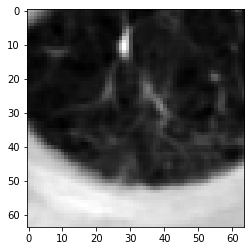

In [4]:
ct_slices = img_data['ct_slices']
slice_class = img_data['slice_class']

plt.imshow(ct_slices[0], interpolation='nearest',cmap='gray')
plt.show()

In [5]:
print(ct_slices.shape)
print(slice_class.shape)
print(ct_slices[0].min())

(6691, 64, 64)
(6691, 1)
-1017.0


In [35]:
ct_slices = np.array(ct_slices)
slice_class = np.array(slice_class)
ct_slices = ct_slices.reshape(6691, 64, 64, 1)

x_train, x_t, y_train, y_t = train_test_split(ct_slices, slice_class, test_size = 0.3, random_state=11)
x_val, x_test, y_val, y_test = train_test_split(x_t, y_t, test_size = 0.5, random_state=11)

y_train = keras.utils.to_categorical(y_train, num_classes=2)
y_val = keras.utils.to_categorical(y_val, num_classes=2)
y_test = keras.utils.to_categorical(y_test, num_classes=2)

print(x_train.shape)
print(x_test.shape)
print(x_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(4683, 64, 64, 1)
(1004, 64, 64, 1)
(1004, 64, 64, 1)
(4683, 2)
(1004, 2)
(1004, 2)


In [36]:
def identity_block(X, f, filters, stage, block):
    # defining names
    conv_name = 'res'+str(stage)+block+'_branch'
    bn_name = 'bn'+str(stage)+block+'_branch'

    # retrieve filters
    f1, f2, f3 = filters

    # save the input values
    X_skip = X

    # 1st component of main path
    X = Conv2D(filters=f1, kernel_size=(1,1), strides=(1,1), padding='valid', name=conv_name+'2a')(X)
    X = BatchNormalization(name=bn_name+'2a')(X)
    X = Activation('relu')(X)

    # 2nd component of main path
    X = Conv2D(filters=f2, kernel_size=(f,f), strides=(1,1), padding='same', name=conv_name+'2b')(X)
    X = BatchNormalization(name=bn_name+'2b')(X)
    X = Activation('relu')(X)

    # 3rd component of main path
    X = Conv2D(filters=f3, kernel_size=(1,1), strides=(1,1), padding='valid', name=conv_name+'2c')(X)
    X = BatchNormalization(name=bn_name+'2c')(X)
    
    # Final Step
    X = Add()([X, X_skip])
    X = Activation('relu')(X)

    return X

In [37]:
def conv_block(X, f, filters, stage, block, s=2):
    # defining names
    conv_name = 'res'+str(stage)+block+'_branch'
    bn_name = 'bn'+str(stage)+block+'_branch'

    # retrieve filters
    f1, f2, f3 = filters

    # save the input values
    X_skip = X

    # 1st component of main path
    X = Conv2D(filters=f1, kernel_size=(1,1), strides=(s,s), padding='valid', name=conv_name+'2a')(X)
    X = BatchNormalization(name=bn_name+'2a')(X)
    X = Activation('relu')(X)

    # 2nd component of main path
    X = Conv2D(filters=f2, kernel_size=(f,f), strides=(1,1), padding='same', name=conv_name+'2b')(X)
    X = BatchNormalization(name=bn_name+'2b')(X)
    X = Activation('relu')(X)

    # 3rd component of main path
    X = Conv2D(filters=f3, kernel_size=(1,1), strides=(1,1), padding='valid', name=conv_name+'2c')(X)
    X = BatchNormalization(name=bn_name+'2c')(X)

    # res skip connection path
    X_skip = Conv2D(filters=f3, kernel_size=(1,1), strides=(s,s), padding='valid', name=conv_name+'1')(X_skip)
    X_skip = BatchNormalization(name=bn_name+'1')(X_skip)
    
    # Final Step
    X = Add()([X, X_skip])
    X = Activation('relu')(X)

    return X

In [38]:
def ResNet(input_shape = (64, 64, 1), classes = 2):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = conv_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = conv_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    

    # Stage 4
    X = conv_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), padding='same')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet')

    return model

In [39]:
# Creating function to get a untrained model from tensorflow
tf.keras.backend.clear_session()
tf.random.set_seed(11)

def get_model():
  model = ResNet()
  
  model.compile(
        loss='categorical_crossentropy',
        optimizer='Adam',
        metrics=['accuracy']
    )
  
  return model

summary = get_model().summary()
summary

Model: "ResNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 32, 32, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1[0][0]']                  
                                                                                             

In [40]:
model = get_model()

callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min",
    restore_best_weights=True,
)

history = model.fit(
    x_train, y_train,
    batch_size = 128,
    validation_data=(x_val, y_val),
    epochs=50,
)

Epoch 1/50
37/37 [==============================] - 7s 122ms/step - loss: 1.3929 - accuracy: 0.6306 - val_loss: 14.3844 - val_accuracy: 0.4084
Epoch 2/50
37/37 [==============================] - 3s 80ms/step - loss: 0.5077 - accuracy: 0.7798 - val_loss: 4.0517 - val_accuracy: 0.6185
Epoch 3/50
37/37 [==============================] - 3s 80ms/step - loss: 0.3319 - accuracy: 0.8764 - val_loss: 0.9787 - val_accuracy: 0.6295
Epoch 4/50
37/37 [==============================] - 3s 81ms/step - loss: 0.1856 - accuracy: 0.9265 - val_loss: 0.7486 - val_accuracy: 0.6325
Epoch 5/50
37/37 [==============================] - 3s 81ms/step - loss: 0.1311 - accuracy: 0.9502 - val_loss: 0.7229 - val_accuracy: 0.6793
Epoch 6/50
37/37 [==============================] - 3s 81ms/step - loss: 0.0624 - accuracy: 0.9776 - val_loss: 0.9398 - val_accuracy: 0.7072
Epoch 7/50
37/37 [==============================] - 3s 81ms/step - loss: 0.0600 - accuracy: 0.9774 - val_loss: 0.5366 - val_accuracy: 0.7888
Epoch 8/50


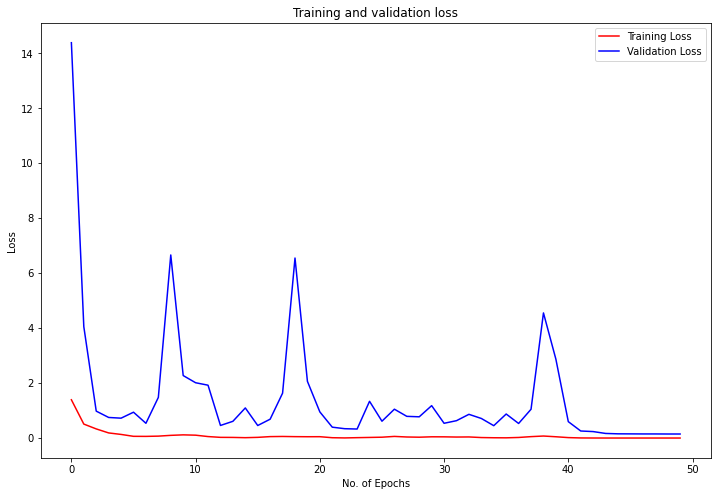

In [41]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure(figsize=(12,8))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend()

#plt.savefig('/content'+'/ANN Training and Validation Loss - '+'LH Borderline 1.png',dpi=300) ##########

plt.show()

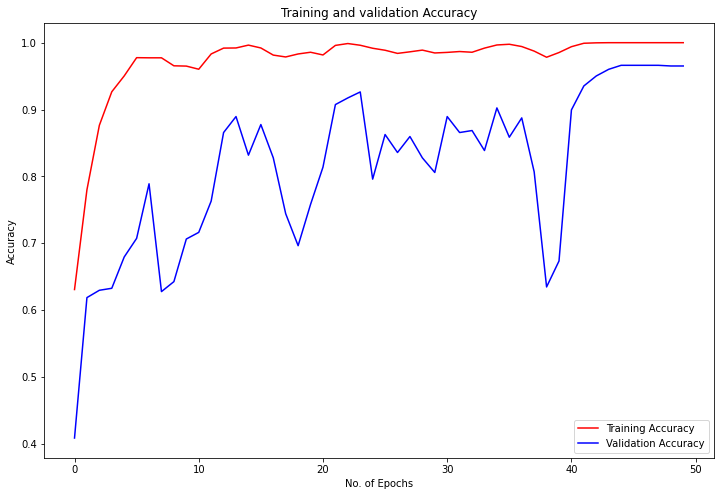

In [42]:
# result of the model training

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(loss))

plt.figure(figsize=(12,8))

plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()

#plt.savefig('/content'+'/ANN Training and Validation Accuracy - '+'LH Borderline 1.png',dpi=300) #########

plt.show()